<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_HbridgeCascadedMultilevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>PWM of H-Bridge Cascaded Multilevel Inverter</h1></b>

Dr. Bingsen Wang

11/26/2023
</center>

#Python Code
The Python code illustrates the output waveform of H-bridge cascaded Multilevel (HBCM) inverters.

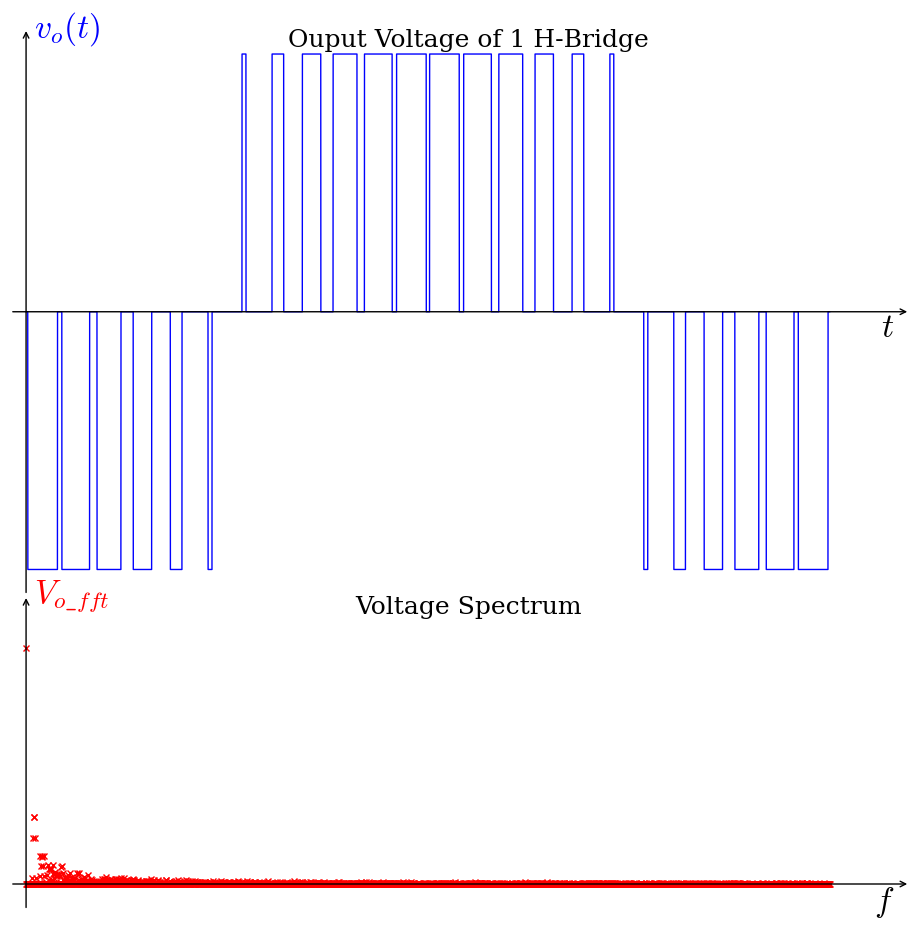

In [39]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,sin,random,arccos,heaviside,array,fft,abs, angle,sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,theta,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t+theta))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

def vo_1brg(MI,f_m,theta_m,f_c,theta_c,t): #output voltage of one bridge
  mt = m(MI,f_m,theta_m,t)
  ct1 = carr(f_c,theta_c,t)
  ct2 = carr(f_c,theta_c+pi,t)
  return h(mt,ct1)+h(mt,ct2)-1

def vo_total(MI,f_m,theta_m,f_c,theta_shift,n_brg,t): #total output voltage
  vo=0
  for k in range(n_brg):
    vo += vo_1brg(MI,f_m,theta_m,f_c,theta_shift/n_brg*k,t)
  return vo/n_brg

#spectrum
def spectrum(xt): #spectrum - magnitude and angle
  xfft = fft.rfft(xt)
  xfft_angle = angle(xfft)
  xfft_mag = abs(xfft)/len(xt)*2
  xfft_mag[0]=xfft_mag[0]*0.5 #adjust the dc component
  return xfft_mag,xfft_angle

#parameters
Nf = 24 # number of frames
Nhb_max = Nf+1 # number of h-bridges
Np = 4096*Nhb_max # number of points

MI = 0.9 # modulation index
f_m = 1 # modulation frequency
theta_m=0 #modulation phase angle
f_c = 12*f_m # carrier frequency
theta_shift=pi #total phase shift among the H-bridges

#time series
t = linspace(0,1,Np)

#frequency series
fser = linspace(0,1,int(f_c*Nhb_max*8)+1) #frequency series for plotting

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, .35,  1, .63], [-.02,1.1], [-1.1,1.1]], # ac output
            [[0, 0,  1, .35], [-.02,1.1], [-.1,1.1]], # load current
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[[['$v_o(t)$'], '$t$'],
        [['$V_{o\_fft}$'], '$f$'],
        ] #yx axes labels
title_lst = ['AC Voltage',
             'Voltage Spectrum',]
clst=[['b'], ['r']] #colors of lines
ax_lst=[] #axis list or the list of subplots
tx_lst=[]
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  if k==1:
    lines.append(ax.plot([], [], color='r', ls='',marker='x',markersize=5,)[0]) # lines to plot
  for kk in range(len(ax_lbl[k][0])):
    lines.append(ax.plot([], [], clst[k][kk], lw=1)[0]) # lines to plot
    ax.text(0.01+0.1*kk,ym,ax_lbl[k][0][kk],size=24,va='center',color=clst[k][kk]) #y labels
  ax.text(xm-.02,0,ax_lbl[k][1],size=24,va='top',ha='right') #x-axis label
  tx_lst.append(ax.text(0.55,ax_frame[k][2][1],title_lst[k],color='k',
                        va='top',ha='center',size=18))

# animation function. This is called sequentially
def animate(i):
  Nhb = 1+i
  vot = vo_total(MI,f_m,theta_m,f_c,theta_shift,Nhb,t)
  vo_fft = spectrum(vot)
  lines[0].set_data(t, vot) #ac voltage
  lines[1].set_data(fser,vo_fft[0][:len(fser)])
  if Nhb==1:
    tx_lst[0].set_text('Ouput Voltage of '+ str(Nhb)+ ' H-Bridge')
  else:
    tx_lst[0].set_text('Ouput Voltage of '+ str(Nhb)+ ' H-Bridges in Series')
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf+1, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_HbridgeCascadedMultilevel.mp4"
writervideo = animation.FFMpegWriter(fps=1)
anim.save(fn, writer=writervideo,dpi = 120)